In [1]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../../dataset/data0test.txt'
data0Label = r'../../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

In [2]:
# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

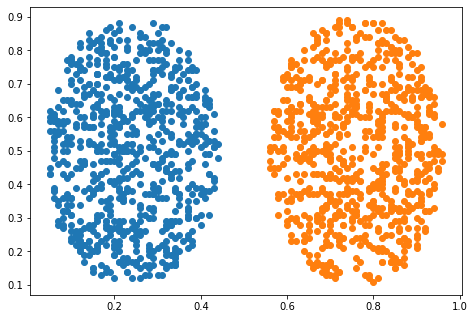

In [3]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

In [4]:
from IPython.display import Image

# Loss function Two-Qubit

Loss is calculated with a simple two-qubit gate. First, the data is embedded into Rx rotation with pi/4 rotation of Ry and Rz. The parameterized quantum circuit is placed after the embedding. We used same structure of the circuit1 from the paper to check the convergence.

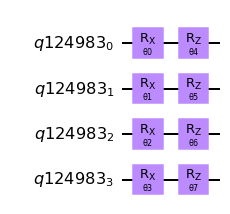

In [9]:
from circuits import *
from qiskit.circuit import Parameter

#circuit 1
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)

theta=[]
for i in range(62):
    theta.append((Parameter('θ'+str(i))))
qc=circuit1(qc,qr,theta,1,0)
qc.draw('mpl')

In [14]:
#load the simulation functcions from the quantumcircuit.py file

from quantumcircuit import *

#location,label,param,[circuit#,layer]
loss_qubitF([0.5,0.5],-1,[0,0,0,-5,0,0,0,0],[0,1])


2

## [SPSA method](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation)

SPSA is an algorithm used in numerical optimization.

Consider a loss function $L(\mathbf{x})$. In order to optimize $L$, SPSA iteratively optimizes the parameters of the loss function according to the following update rule:

$$\mathbf{y}_{n+1} = \mathbf{y}_{n} - a_{n}\widehat{\Delta L}_{n}(\mathbf{y}_{n}),$$

where $\widehat{\Delta L}_{n}(\mathbf{y}_{n}))$ is an estimate of the gradient at $\mathbf{y}_{n}$.

How SPSA calculates that gradient is by using a finite-difference rule on random perturbations of component of the parameter vector.
    $$\left( \widehat{\Delta L}_{n}(\mathbf{y}_{n}))\right)_{j} = \frac{L(\mathbf{y}_{n} + c_{n}\boldsymbol{\Delta}_{n}) - L(\mathbf{y}_{n} - c_{n}\boldsymbol{\Delta}_{n}) }{c_{n}\left(\boldsymbol{\Delta}_{n}\right)_{j}}$$
    
That is at each iteration, SPSA generates a random perturbation $\boldsymbol{\Delta}_{n}$, and does a finite-difference rule with that perturbation.

In order for the algorithm to converge, the random perturbation $\boldsymbol{\Delta}_{n}$ and finite-difference coefficients $c_{n}$ must satisfy certain properties (see the Wikipedia article linked to in the title). Importantly $c_{n}$ must tend to 0 as $n$ increases, and the size of the random fluctuations $\boldsymbol{\Delta}_{n}$ must also be bounded.

According to the wikipedia article, the coefficients $a_{n}$ and $c_{n}$ should look something like

$$c_{n} = \frac{c}{n^\gamma}~~\text{and}~~a_{n} = \frac{a}{n}.$$

In [7]:
#load the SPSA optimizer from the optimizer.py file
from optimizer import *

# Test the convergence of 100 data point

To have sanity check, we take 100 data and run the optimization.

In [ ]:
c = 1
a = 1


# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(2)
currentParams = pi*np.random.uniform(size=8)
for j in range(50):  
    
    cj = c/(j+1)**(1/3)
    aj = a/(j+1)

    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(2)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=30)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss_qubitF(data[j][0],data[j][1],x,[0,1]) for j in data_ixs])/len(data_ixs) 
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([predict_qubitF(data[j][0],currentParams,[0,1]) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 1.1333333333333333 Accuracy = 0.4
1 th iteration L= 0.3333333333333333 Accuracy = 0.8333333333333334
2 th iteration L= 0.26666666666666666 Accuracy = 0.8333333333333334


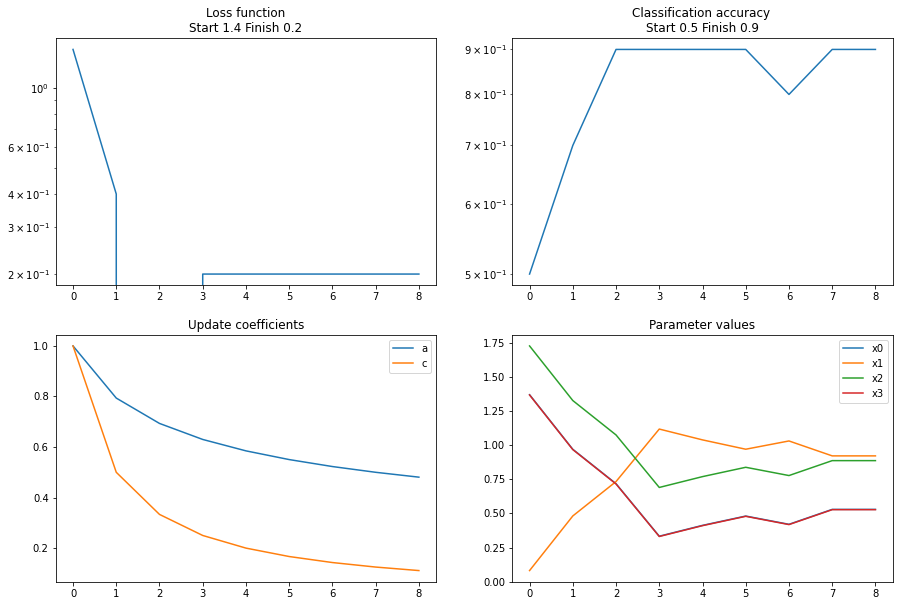

In [16]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

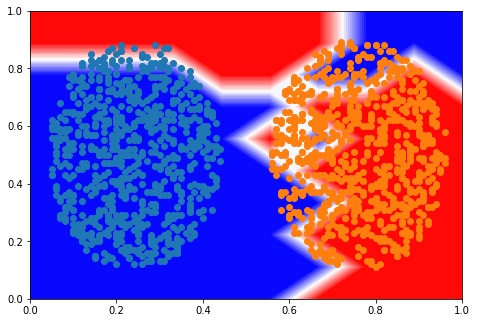

In [18]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=10)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = predict_qubitF( np.array([X[k], X[j]]),currentParams,[0,1])
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

# 0.5

In [27]:
c = 1
a = 1
aparam=0.5*pi

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(2)
currentParams = pi*np.random.uniform(size=8)
for j in range(50): 
    
    cj = c/(j+1)**(1/3)
    aj = a/(j+1)

    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(2)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=100)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss_qubitF(aparam*data[j][0],aparam*data[j][1],x,[0,1]) for j in data_ixs])/len(data_ixs) 
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([predict_qubitF(data[j][0],currentParams,[0,1]) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 1.8907963267948966 Accuracy = 0.44
1 th iteration L= 1.6107963267948964 Accuracy = 0.55
2 th iteration L= 1.5307963267948963 Accuracy = 0.52
3 th iteration L= 1.5507963267948965 Accuracy = 0.56
4 th iteration L= 1.5507963267948965 Accuracy = 0.49
5 th iteration L= 1.5307963267948965 Accuracy = 0.56
6 th iteration L= 1.5307963267948963 Accuracy = 0.5
7 th iteration L= 1.5307963267948963 Accuracy = 0.5
8 th iteration L= 1.5507963267948965 Accuracy = 0.57
9 th iteration L= 1.5507963267948965 Accuracy = 0.48
10 th iteration L= 1.5307963267948963 Accuracy = 0.54
11 th iteration L= 1.5107963267948963 Accuracy = 0.52
12 th iteration L= 1.5507963267948965 Accuracy = 0.54
13 th iteration L= 1.5507963267948965 Accuracy = 0.52
14 th iteration L= 1.5507963267948965 Accuracy = 0.58
15 th iteration L= 1.5307963267948965 Accuracy = 0.51
16 th iteration L= 1.5507963267948965 Accuracy = 0.54
17 th iteration L= 1.5507963267948965 Accuracy = 0.56
18 th iteration L= 1.5307963267948965 Ac

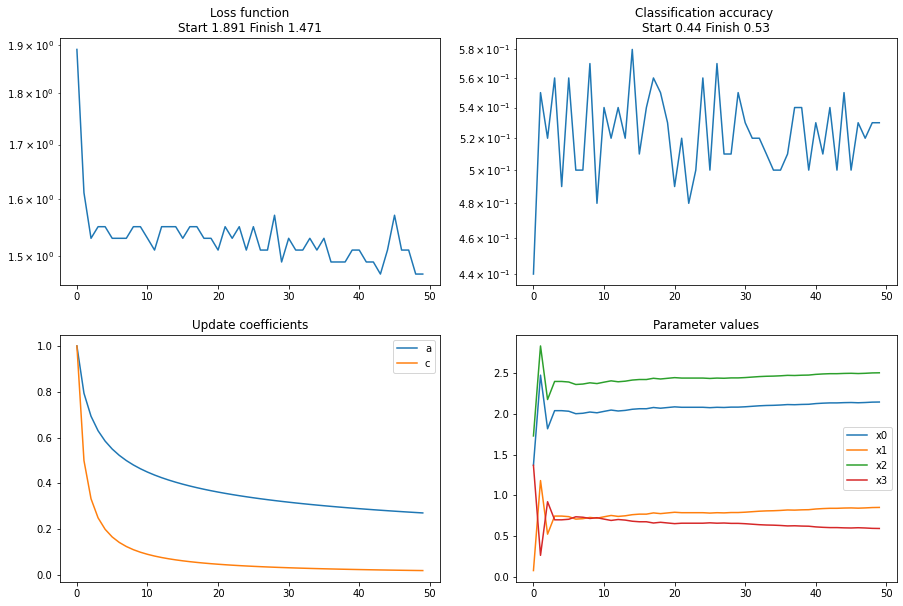

In [28]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

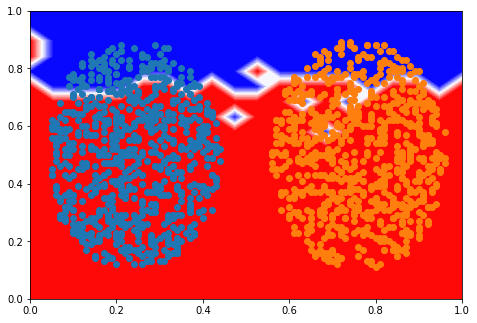

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=20)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = predict_qubitF( np.array([X[k], X[j]]),currentParams,[0,1])
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

# 1.0

In [30]:
c = 1
a = 1
aparam=1.0*pi

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(2)
currentParams = pi*np.random.uniform(size=8)
for j in range(50):    
    
    cj = c/(j+1)**(1/3)
    aj = a/(j+1)

    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(2)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=100)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss_qubitF(aparam*data[j][0],aparam*data[j][1],x,[0,1]) for j in data_ixs])/len(data_ixs) 
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([predict_qubitF(data[j][0],currentParams,[0,1]) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 2.7215926535897927 Accuracy = 0.48
1 th iteration L= 2.361592653589793 Accuracy = 0.48
2 th iteration L= 2.361592653589793 Accuracy = 0.5
3 th iteration L= 2.381592653589793 Accuracy = 0.55
4 th iteration L= 2.381592653589793 Accuracy = 0.55
5 th iteration L= 2.361592653589793 Accuracy = 0.54
6 th iteration L= 2.361592653589793 Accuracy = 0.52
7 th iteration L= 2.361592653589793 Accuracy = 0.49
8 th iteration L= 2.361592653589793 Accuracy = 0.5
9 th iteration L= 2.361592653589793 Accuracy = 0.52
10 th iteration L= 2.361592653589793 Accuracy = 0.53
11 th iteration L= 2.381592653589793 Accuracy = 0.53
12 th iteration L= 2.361592653589793 Accuracy = 0.49
13 th iteration L= 2.361592653589793 Accuracy = 0.57
14 th iteration L= 2.361592653589793 Accuracy = 0.5
15 th iteration L= 2.361592653589793 Accuracy = 0.49
16 th iteration L= 2.361592653589793 Accuracy = 0.51
17 th iteration L= 2.361592653589793 Accuracy = 0.54
18 th iteration L= 2.361592653589793 Accuracy = 0.53
19 th

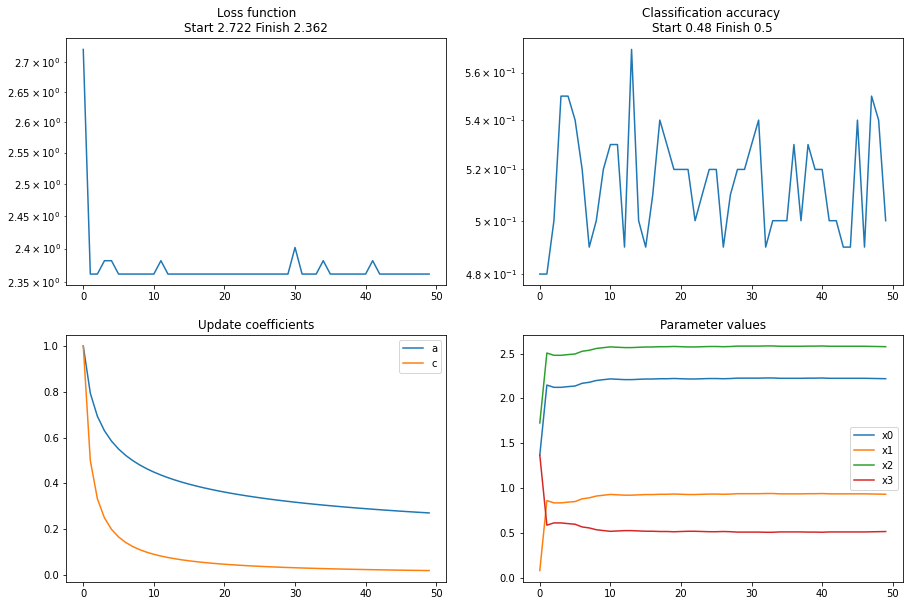

In [31]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

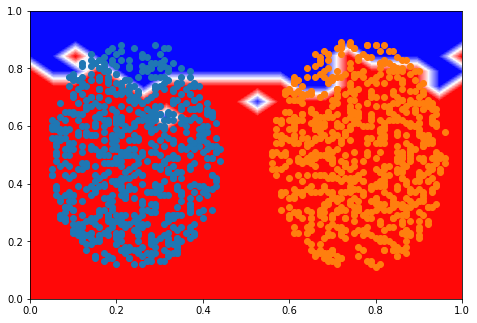

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=20)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = predict_qubitF( np.array([X[k], X[j]]),currentParams,[0,1])
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

# 2.0

In [33]:
c = 1
a = 1
aparam=2.0*pi

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(2)
currentParams = pi*np.random.uniform(size=8)
for j in range(50):     
    
    cj = c/(j+1)**(1/3)
    aj = a/(j+1)

    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(2)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=100)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss_qubitF(aparam*data[j][0],aparam*data[j][1],x,[0,1]) for j in data_ixs])/len(data_ixs) 
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([predict_qubitF(data[j][0],currentParams,[0,1]) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 6.583185307179585 Accuracy = 0.36
1 th iteration L= 6.503185307179585 Accuracy = 0.22
2 th iteration L= 6.523185307179586 Accuracy = 0.15
3 th iteration L= 6.463185307179585 Accuracy = 0.08
4 th iteration L= 6.363185307179585 Accuracy = 0.08
5 th iteration L= 6.263185307179586 Accuracy = 0.12
6 th iteration L= 6.163185307179585 Accuracy = 0.13
7 th iteration L= 6.203185307179585 Accuracy = 0.19
8 th iteration L= 6.203185307179585 Accuracy = 0.19
9 th iteration L= 6.163185307179585 Accuracy = 0.23
10 th iteration L= 6.163185307179585 Accuracy = 0.27
11 th iteration L= 6.143185307179586 Accuracy = 0.3
12 th iteration L= 6.183185307179586 Accuracy = 0.32
13 th iteration L= 6.263185307179586 Accuracy = 0.35
14 th iteration L= 6.243185307179585 Accuracy = 0.38
15 th iteration L= 6.263185307179586 Accuracy = 0.36
16 th iteration L= 6.263185307179586 Accuracy = 0.37
17 th iteration L= 6.263185307179586 Accuracy = 0.44
18 th iteration L= 6.283185307179585 Accuracy = 0.38
19 t

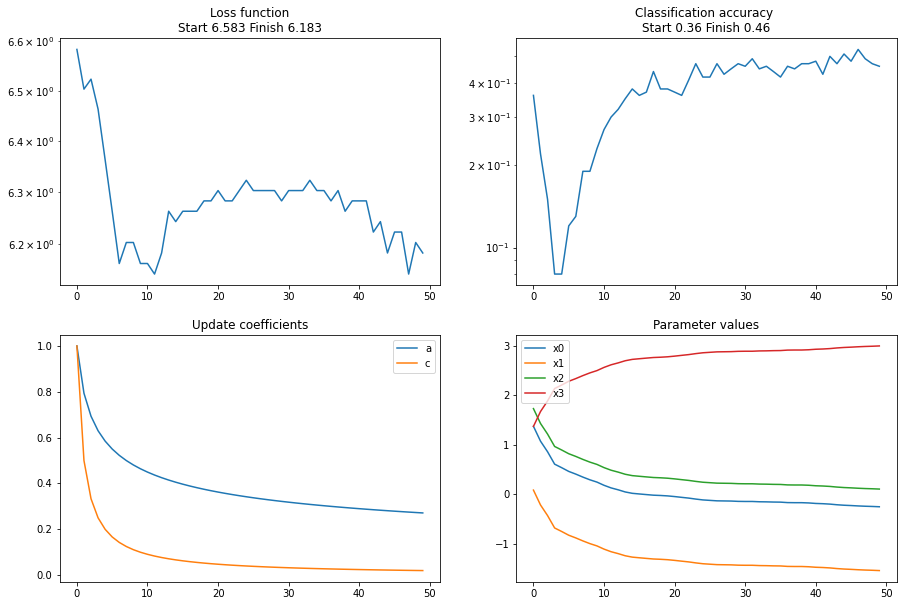

In [34]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

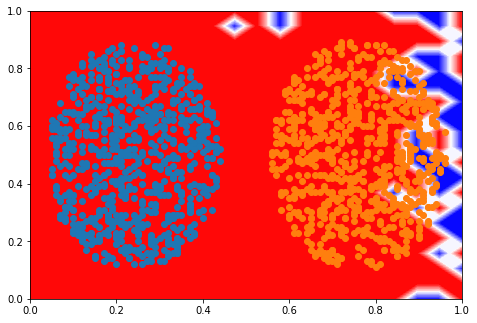

In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=20)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = predict_qubitF( np.array([X[k], X[j]]),currentParams,[0,1])
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

# 4.0

In [36]:
c = 1
a = 1
aparam=4.0*pi

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(2)
currentParams = pi*np.random.uniform(size=8)
for j in range(50):      
    
    cj = c/(j+1)**(1/3)
    aj = a/(j+1)

    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(2)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=100)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss_qubitF(aparam*data[j][0],aparam*data[j][1],x,[0,1]) for j in data_ixs])/len(data_ixs) 
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([predict_qubitF(data[j][0],currentParams,[0,1]) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 12.68637061435917 Accuracy = 0.41
1 th iteration L= 12.706370614359171 Accuracy = 0.41
2 th iteration L= 12.72637061435917 Accuracy = 0.45
3 th iteration L= 12.72637061435917 Accuracy = 0.43
4 th iteration L= 12.72637061435917 Accuracy = 0.39
5 th iteration L= 12.72637061435917 Accuracy = 0.47
6 th iteration L= 12.68637061435917 Accuracy = 0.48
7 th iteration L= 12.64637061435917 Accuracy = 0.49
8 th iteration L= 12.58637061435917 Accuracy = 0.5
9 th iteration L= 12.56637061435917 Accuracy = 0.57
10 th iteration L= 12.606370614359172 Accuracy = 0.49
11 th iteration L= 12.56637061435917 Accuracy = 0.43
12 th iteration L= 12.56637061435917 Accuracy = 0.54
13 th iteration L= 12.56637061435917 Accuracy = 0.56
14 th iteration L= 12.526370614359172 Accuracy = 0.53
15 th iteration L= 12.50637061435917 Accuracy = 0.56
16 th iteration L= 12.546370614359171 Accuracy = 0.59
17 th iteration L= 12.526370614359172 Accuracy = 0.54
18 th iteration L= 12.526370614359172 Accuracy = 0.5

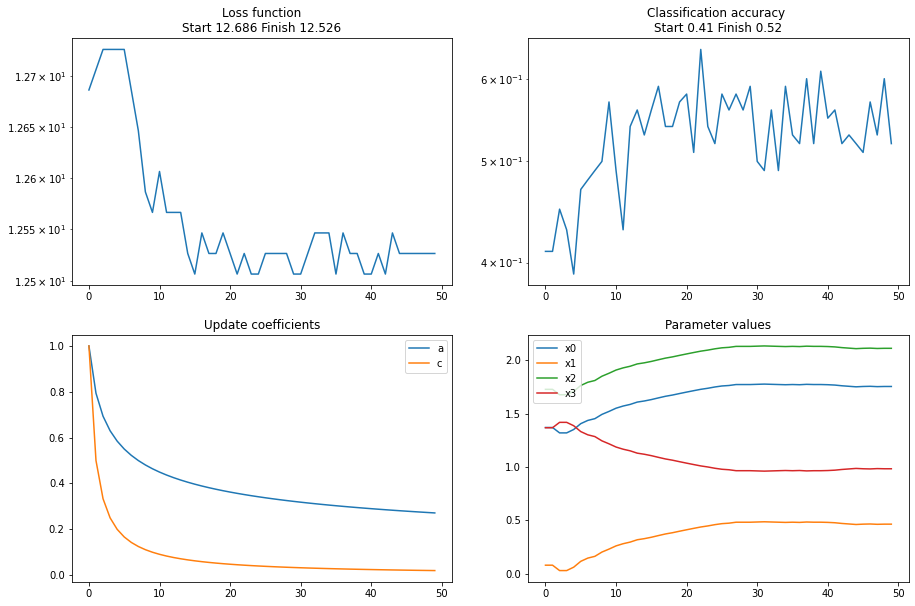

In [37]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

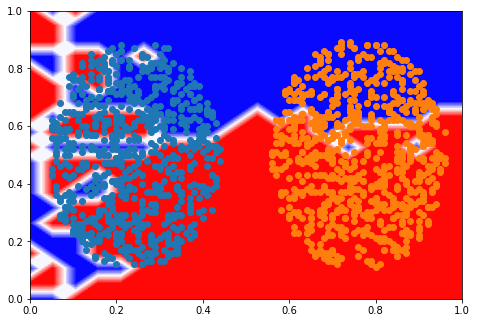

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=20)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = predict_qubitF( np.array([X[k], X[j]]),currentParams,[0,1])
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

# 8.0

In [39]:
c = 1
a = 1
aparam=8.0*pi

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(2)
currentParams = pi*np.random.uniform(size=8)
for j in range(50):  
    
    cj = c/(j+1)**(1/3)
    aj = a/(j+1)

    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(2)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=100)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss_qubitF(aparam*data[j][0],aparam*data[j][1],x,[0,1]) for j in data_ixs])/len(data_ixs) 
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([predict_qubitF(data[j][0],currentParams,[0,1]) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 25.01274122871834 Accuracy = 0.39
1 th iteration L= 25.03274122871834 Accuracy = 0.43
2 th iteration L= 25.03274122871834 Accuracy = 0.44
3 th iteration L= 25.03274122871834 Accuracy = 0.47
4 th iteration L= 25.03274122871834 Accuracy = 0.42
5 th iteration L= 25.01274122871834 Accuracy = 0.42
6 th iteration L= 25.01274122871834 Accuracy = 0.4
7 th iteration L= 25.01274122871834 Accuracy = 0.39
8 th iteration L= 25.052741228718343 Accuracy = 0.35
9 th iteration L= 25.03274122871834 Accuracy = 0.37
10 th iteration L= 25.01274122871834 Accuracy = 0.37
11 th iteration L= 24.99274122871834 Accuracy = 0.35
12 th iteration L= 25.03274122871834 Accuracy = 0.38
13 th iteration L= 25.03274122871834 Accuracy = 0.35
14 th iteration L= 25.01274122871834 Accuracy = 0.41
15 th iteration L= 25.03274122871834 Accuracy = 0.35
16 th iteration L= 25.03274122871834 Accuracy = 0.31
17 th iteration L= 25.01274122871834 Accuracy = 0.41
18 th iteration L= 25.03274122871834 Accuracy = 0.4
19 t

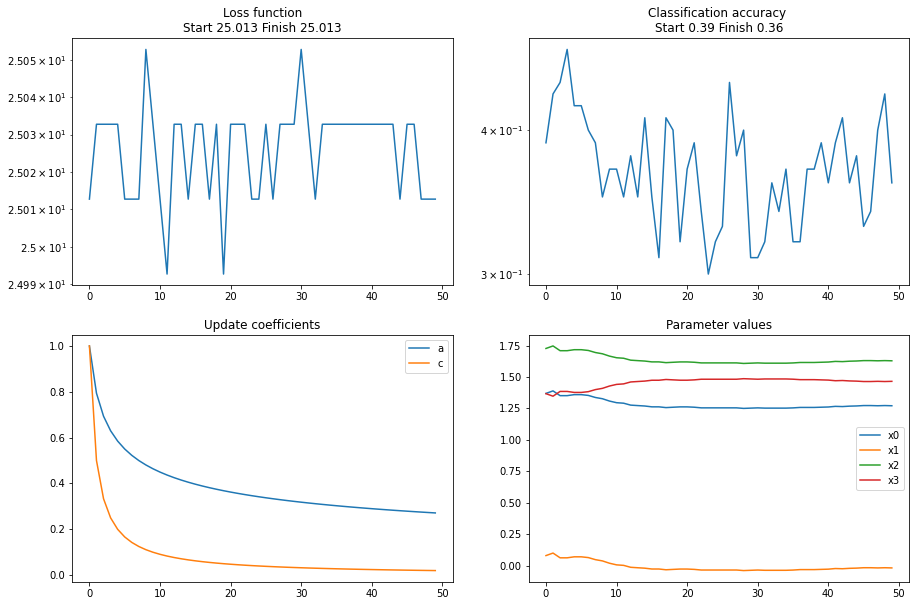

In [40]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

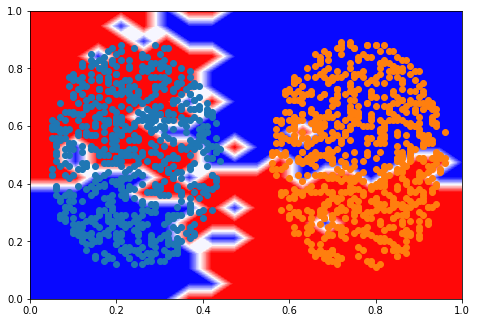

In [41]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=20)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = predict_qubitF( np.array([X[k], X[j]]),currentParams,[0,1])
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)